# Проект по Байесовским методам в машинном обучении
## Bayesian Phillips Curve
### Выполнили: BEGI team

In [43]:
import numpy as np
import pandas as pd

import pymc as pm
import xarray as xr
import scipy.stats
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import arviz as az
import seaborn as sns

import nutpie
import dask.distributed
from dask.diagnostics import ProgressBar

az.style.use("arviz-white")
%matplotlib inline

/usr/local/lib/python3.9/dist-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(


In [44]:
data = pd.read_excel('bayes_data.xlsx')
data.head()

,date,rgdp,cpi,cpi_yoy,usd,eur,brent,y_sa,y_trend
0,1999Q1,9949.383884,1.160048,2.075844,22.918667,25.707833,11.563175,10665.344084,10807.668875
1,1999Q2,10661.489976,1.073288,2.206737,24.497705,25.919672,15.847705,10979.211790,11020.925971
2,1999Q3,11752.563807,1.055521,1.620304,24.816818,26.012879,20.689846,11251.685370,11234.094115
3,1999Q4,12109.408489,1.039098,1.365576,26.267302,27.308889,23.865079,11571.039919,11447.058281
4,2000Q1,11085.791664,1.040560,1.224917,28.489180,28.127049,26.551406,11915.633217,11659.714439


### EDA 

In [45]:
data[["usd", "brent","y_sa","y_trend"]].describe()

,usd,brent,y_sa,y_trend
count,93.000000,93.000000,93.000000,93.000000
mean,41.000760,62.651903,18852.756572,18852.756572
std,17.941278,29.855750,3748.617771,3706.087543
min,22.918667,11.563175,10665.344084,10807.668875
25%,28.518085,35.205714,15788.218492,16073.336153
50%,31.061963,61.320794,20328.886603,20204.978699
75%,59.015486,77.372698,21694.312020,21732.085562
max,87.347863,122.785538,23807.607273,23384.298384


#### Проверка usd на стационарность

In [46]:
test = sm.tsa.adfuller(np.log(data['usd']))
print ('adf:', test[0]) 
print ('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf: 0.0617605676989176
p-value: 0.9633512262407813
Critical values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}
Есть единичные корни, ряд не стационарен


#### Проверка Y на стационарность

In [47]:
test = sm.tsa.adfuller(np.log(data['y_sa']) - np.log(data['y_trend']))
print ('adf:', test[0]) 
print ('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен') 

adf: -3.9701283587785934
p-value: 0.0015752636418153757
Critical values: {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}
Единичных корней нет, ряд стационарен


### Data transformation

In [48]:
data = data[data['date'] != '2022Q1']

data['target'] = np.where(data['date'] < '2015Q1', 0, 1)
data['y'] = np.log(data['y_sa']) - np.log(data['y_trend'])
data['brent'] = data['brent'] * data['usd']
data['infl'] = (data['cpi'] - 1) * 4

data['d_usd'] = np.log(data['usd']).diff()
data['d_brent'] = np.log(data['brent']).diff()
data['d_y'] = np.log(data['y_sa']).diff()

data['lag_infl'] = data['infl'].shift()
data['lag_d_usd'] = data['d_usd'].shift()
data['lag_d_brent'] = data['d_brent'].shift()
data['lag_d_y'] = data['d_y'].shift()

data = data.iloc[4:, :]
data = data.dropna().reset_index(drop=True)
data['date'] = data.date.str.replace('Q','-Q')

print(data.shape)
data.head()

(88, 19)


,date,rgdp,cpi,cpi_yoy,usd,eur,brent,y_sa,y_trend,target,y,infl,d_usd,d_brent,d_y,lag_infl,lag_d_usd,lag_d_brent,lag_d_y
0,2000-Q1,11085.791664,1.040560,1.224917,28.489180,28.127049,756.427801,11915.633217,11659.714439,0,0.021712,0.162238,0.081199,0.187866,0.029346,0.156393,0.056803,0.199577,0.027987
1,2000-Q2,11752.388687,1.052733,1.201458,28.383279,26.526721,766.934802,12115.088149,11872.036050,0,0.020266,0.210932,-0.003724,0.013795,0.016600,0.162238,0.081199,0.187866,0.029346
2,2000-Q3,12992.152302,1.041443,1.185434,27.792424,25.196818,845.015631,12323.442933,12084.156520,0,0.019608,0.165774,-0.021037,0.096953,0.017052,0.210932,-0.003724,0.013795,0.016600
3,2000-Q4,13110.103184,1.053621,1.202002,27.885556,24.240952,839.368501,12508.583445,12296.361164,0,0.017112,0.214485,0.003345,-0.006705,0.014912,0.165774,-0.021037,0.096953,0.017052
4,2001-Q1,11605.255814,1.070578,1.236679,28.553607,26.351311,749.987245,12613.719968,12509.084854,0,0.008330,0.282314,0.023674,-0.112594,0.008370,0.214485,0.003345,-0.006705,0.014912


In [49]:
data[['y', 'infl']].describe()

,y,infl
count,88.000000,88.000000
mean,-0.000593,0.092762
std,0.024960,0.066691
min,-0.077070,-0.024787
25%,-0.015118,0.047268
50%,-0.003773,0.071175
75%,0.014291,0.136597
max,0.075462,0.297598


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


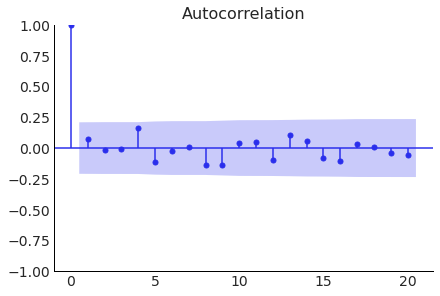

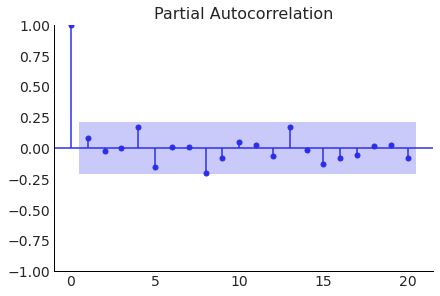

In [50]:
sm.graphics.tsa.plot_acf(data['lag_d_usd'].values.squeeze())
sm.graphics.tsa.plot_pacf(data['lag_d_usd'].values.squeeze())
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


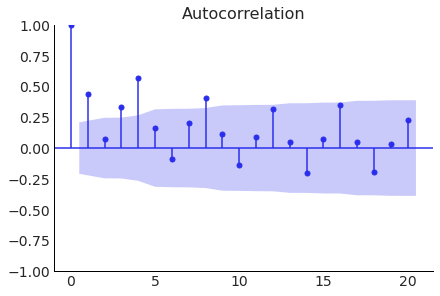

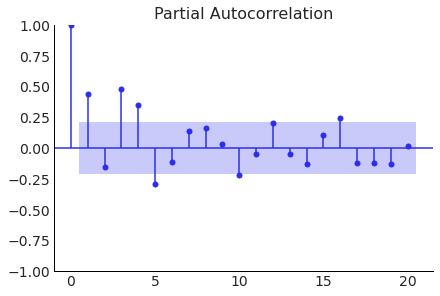

In [51]:
sm.graphics.tsa.plot_acf(data['infl'].values.squeeze())
sm.graphics.tsa.plot_pacf(data['infl'].values.squeeze())
plt.show()

              lag_d_y  lag_d_brent  lag_infl  lag_d_usd
lag_d_y      1.000000     0.583526 -0.009040  -0.373102
lag_d_brent  0.583526     1.000000  0.005797  -0.236933
lag_infl    -0.009040     0.005797  1.000000   0.303620
lag_d_usd   -0.373102    -0.236933  0.303620   1.000000


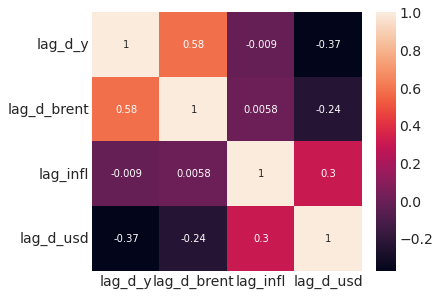

In [52]:
corr_matrix = data[['lag_d_y','lag_d_brent','lag_infl','lag_d_usd']].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True);

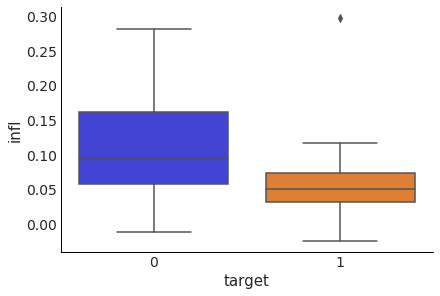

In [53]:
sns.boxplot(x='target', y='infl', data=data);

#### Dynamics of variables without lag

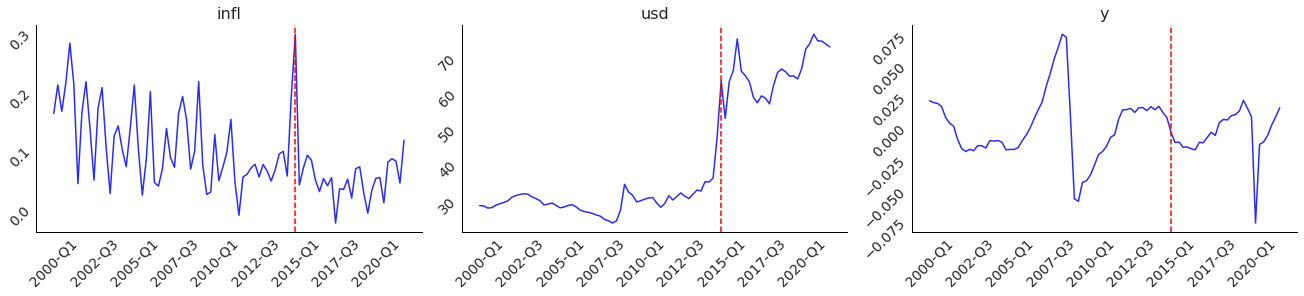

In [54]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
ax[0].plot(data['date'],data['infl'])
ax[0].tick_params(labelrotation=45)
ax[0].set_xticks([0,10,20, 30,40,50,60,70,80,90])
ax[0].axvline(data[data['target'] == 1].index[0],color='red',ls='--')
ax[0].set_title('infl')
ax[1].plot(data['date'],data['usd'])
ax[1].tick_params(labelrotation=45)
ax[1].set_xticks([0,10,20, 30,40,50,60,70,80,90])
ax[1].axvline(data[data['target'] == 1].index[0],color='red',ls='--')
ax[1].set_title('usd')
ax[2].plot(data['date'],data['y'])
ax[2].tick_params(labelrotation=45)
ax[2].set_xticks([0,10,20, 30,40,50,60,70,80,90])
ax[2].axvline(data[data['target'] == 1].index[0],color='red',ls='--')
ax[2].set_title('y')
plt.show()

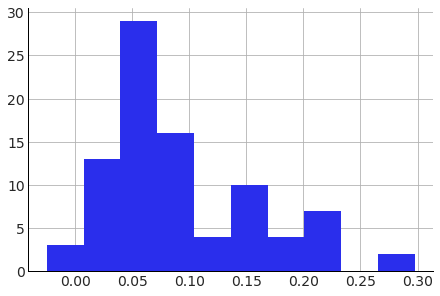

In [55]:
data['infl'].hist();

#### Dynamics of variables with lag

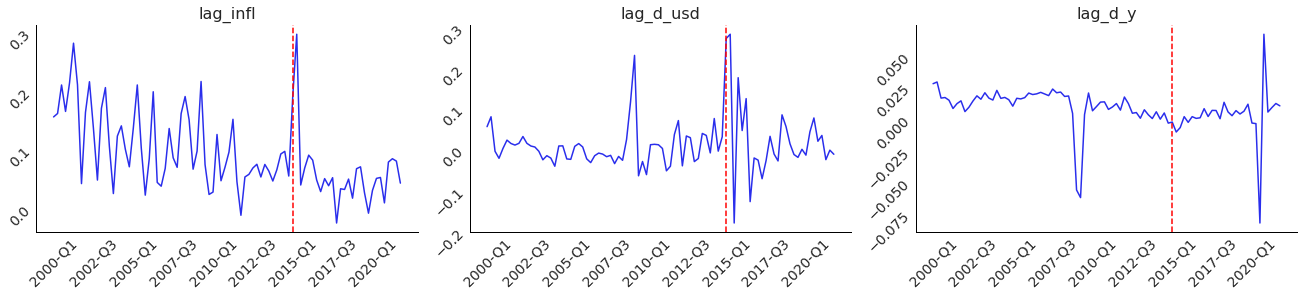

In [56]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
ax[0].plot(data['date'],data['lag_infl'])
ax[0].tick_params(labelrotation=45)
ax[0].set_xticks([0,10,20,30,40,50,60,70,80,90])
ax[0].axvline(data[data['target'] == 1].index[0],color='red',ls='--')
ax[0].set_title('lag_infl')
ax[1].plot(data['date'],data['lag_d_usd'])
ax[1].tick_params(labelrotation=45)
ax[1].set_xticks([0,10,20,30,40,50,60,70,80,90])
ax[1].axvline(data[data['target'] == 1].index[0],color='red',ls='--')
ax[1].set_title('lag_d_usd')
ax[2].plot(data['date'],data['lag_d_y'])
ax[2].tick_params(labelrotation=45)
ax[2].set_xticks([0,10,20,30,40,50,60,70,80,90])
ax[2].axvline(data[data['target'] == 1].index[0],color='red',ls='--')
ax[2].set_title('lag_d_y')
plt.show()

#### Model (economical logic included)

In [57]:
with pm.Model() as model:
    INFL = pm.Data("INFL", data['infl'], mutable=True)
    TARGET = pm.Data("TARGET", data['target'], mutable=True)
    USD = pm.Data("USD", data['lag_d_usd'], mutable=True)
    Y = pm.Data("Y", data['lag_d_y'], mutable=True)
    INFL_LAG = pm.Data("INFL_LAG", data['lag_infl'], mutable=True)

    const = pm.Normal('const', 0.1, 0.06)
    lag_infl = pm.LogNormal('lag_infl', np.log(0.2), 0.5)
    lag_d_usd = pm.Normal('lag_d_usd', 0.2, 0.2)
    lag_d_y = pm.Normal('lag_d_y', 0.3, 1)
    target = pm.Normal('target', -0.2, 0.2)
    uplift_lag_infl = pm.Normal('uplift_lag_infl', -0.1, 0.5)
    uplift_lag_d_usd = pm.Normal('uplift_lag_d_usd', -0.1, 0.2)
    uplift_lag_d_y = pm.Normal('uplift_lag_d_y', -0.15, 1)
    err = pm.Exponential('eps', 100)

    estimate = const + \
                lag_infl * INFL_LAG + lag_d_usd * USD + lag_d_y * Y + \
                (uplift_lag_infl * INFL_LAG + uplift_lag_d_usd * USD + uplift_lag_d_y * Y) * TARGET + \
                target * TARGET
    pm.Normal('infl', estimate, err, observed=INFL)

Sampling: [const, eps, infl, lag_d_usd, lag_d_y, lag_infl, target, uplift_lag_d_usd, uplift_lag_d_y, uplift_lag_infl]


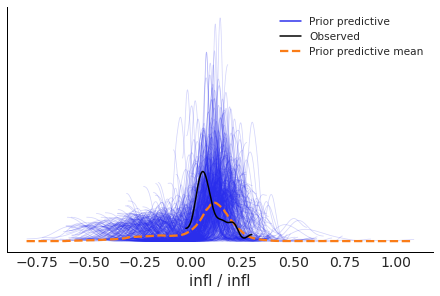

In [58]:
with model:
    prior = pm.sample_prior_predictive()
    
az.plot_ppc(prior, group="prior");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [const, lag_infl, lag_d_usd, lag_d_y, target, uplift_lag_infl, uplift_lag_d_usd, uplift_lag_d_y, eps]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


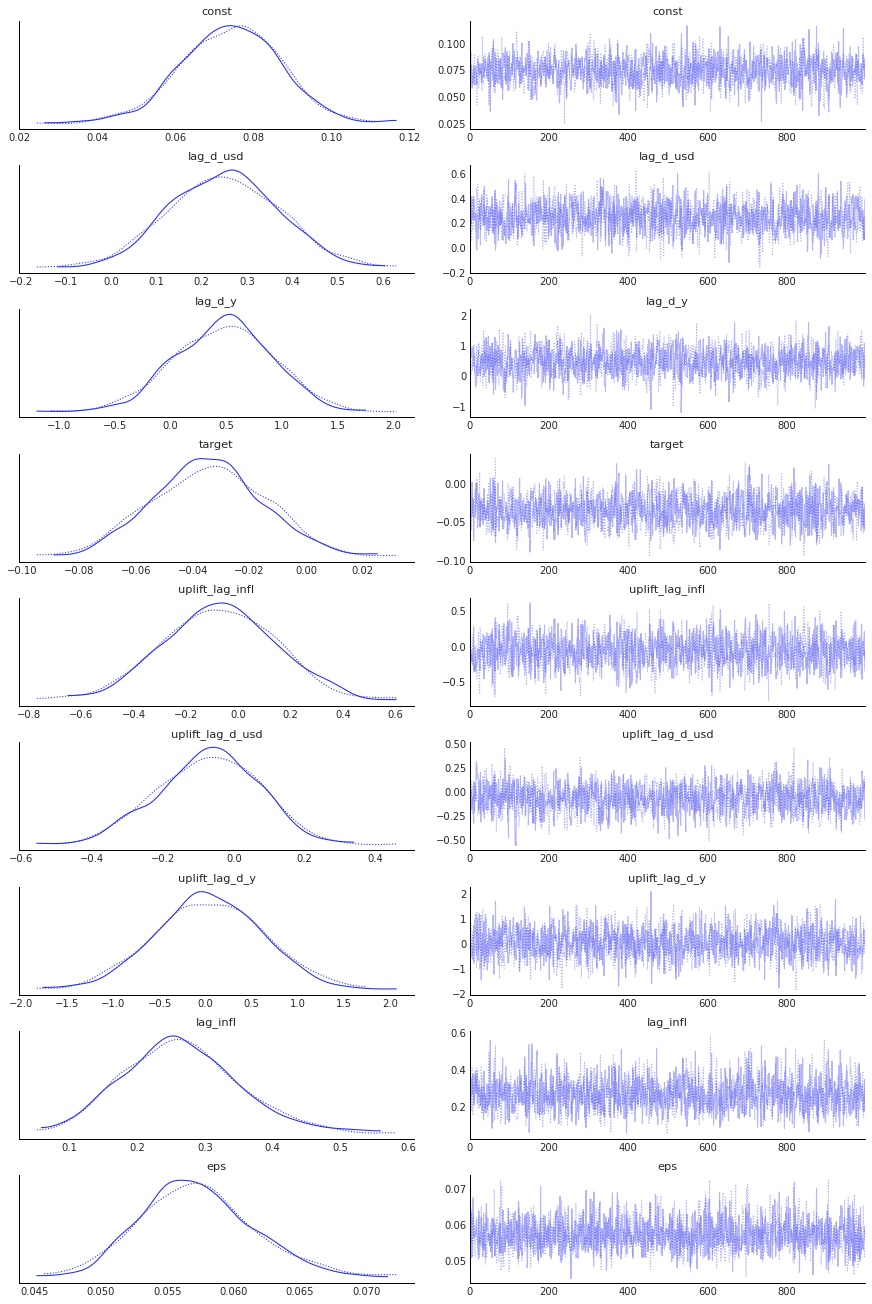

In [59]:
with model:
    trace = pm.sample()
    trace.extend(prior)
    
az.plot_trace(trace);

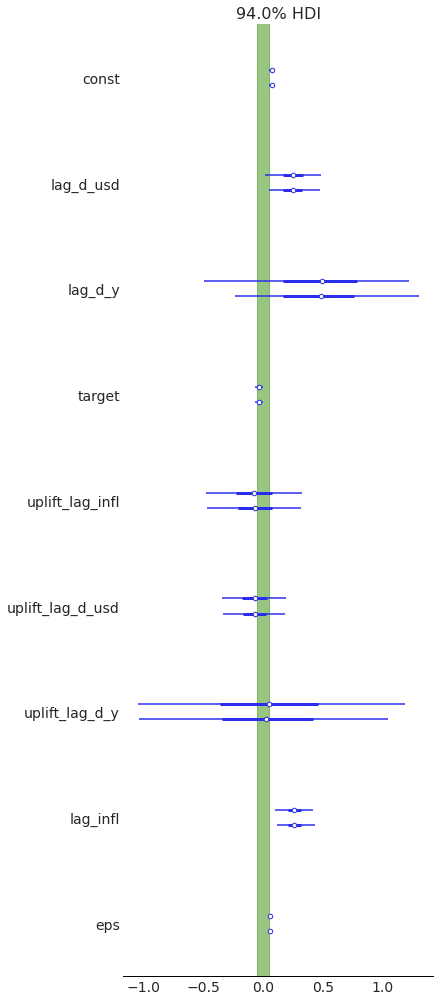

In [60]:
az.plot_forest(trace, rope=[-0.05, 0.05]);

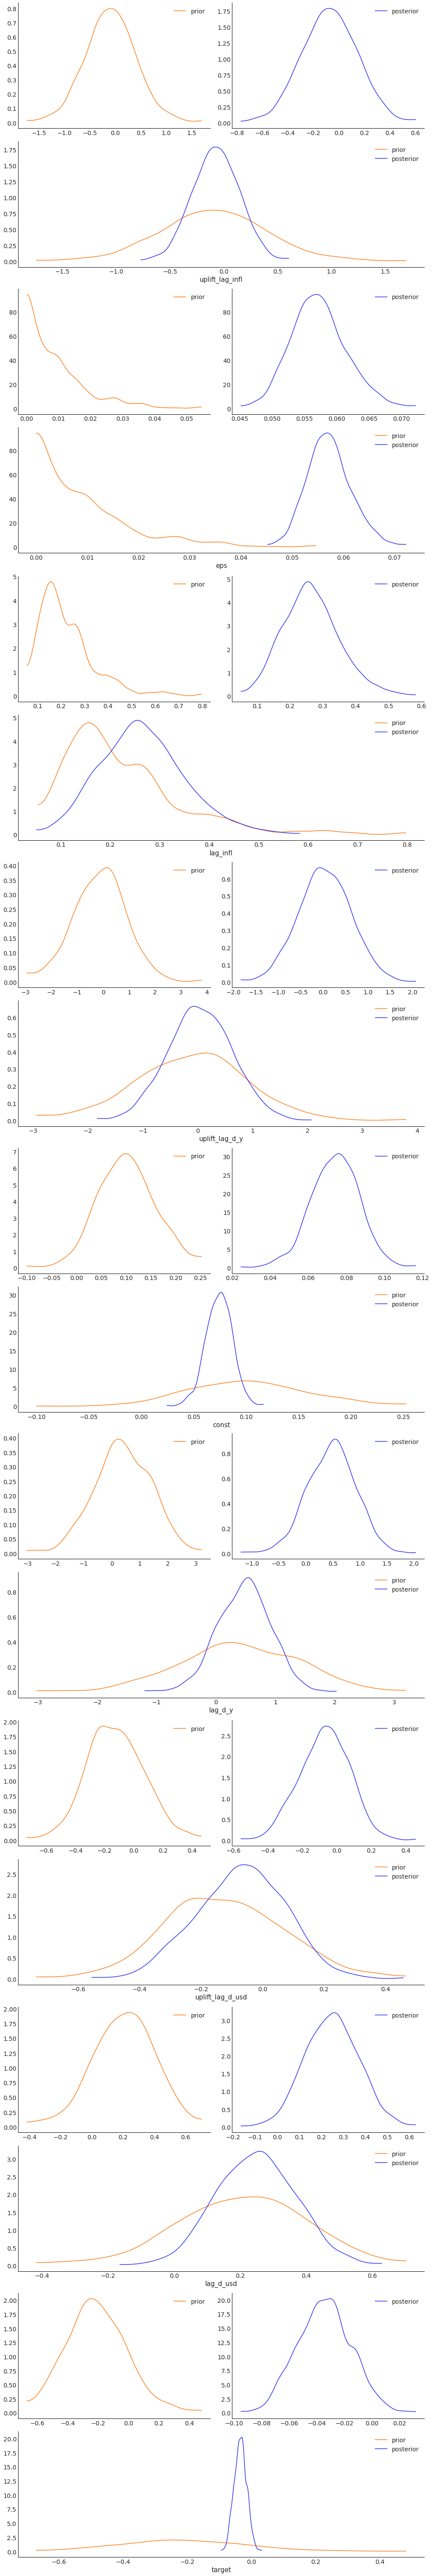

In [61]:
az.plot_dist_comparison(trace);

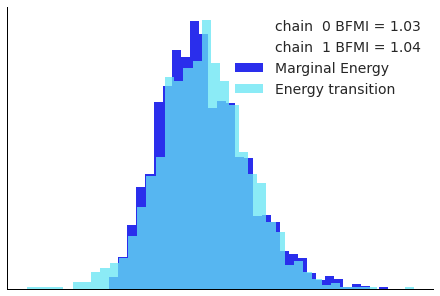

In [62]:
az.plot_energy(trace, kind='hist');

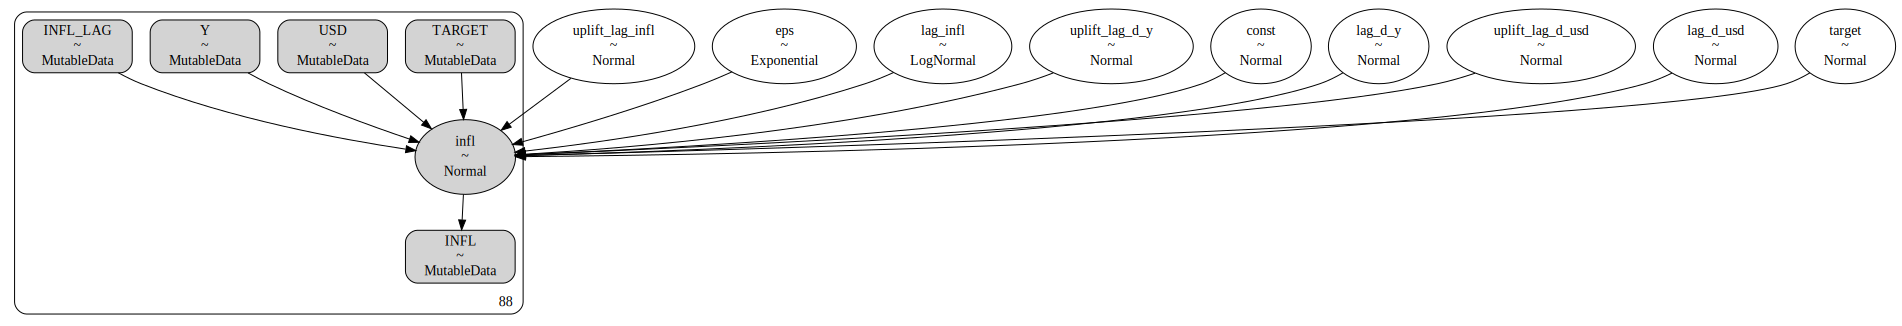

In [63]:
pm.model_to_graphviz(model)

### Baseline model (no economical logic)

#### Теперь возьмем модель, в которую не заложена экономическая логика. Моделируем все переменные нормальным распределением с параметрами 0 и 0,5.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [const, lag_infl, lag_d_usd, lag_d_y, target, uplift_lag_infl, uplift_lag_d_usd, uplift_lag_d_y, eps]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


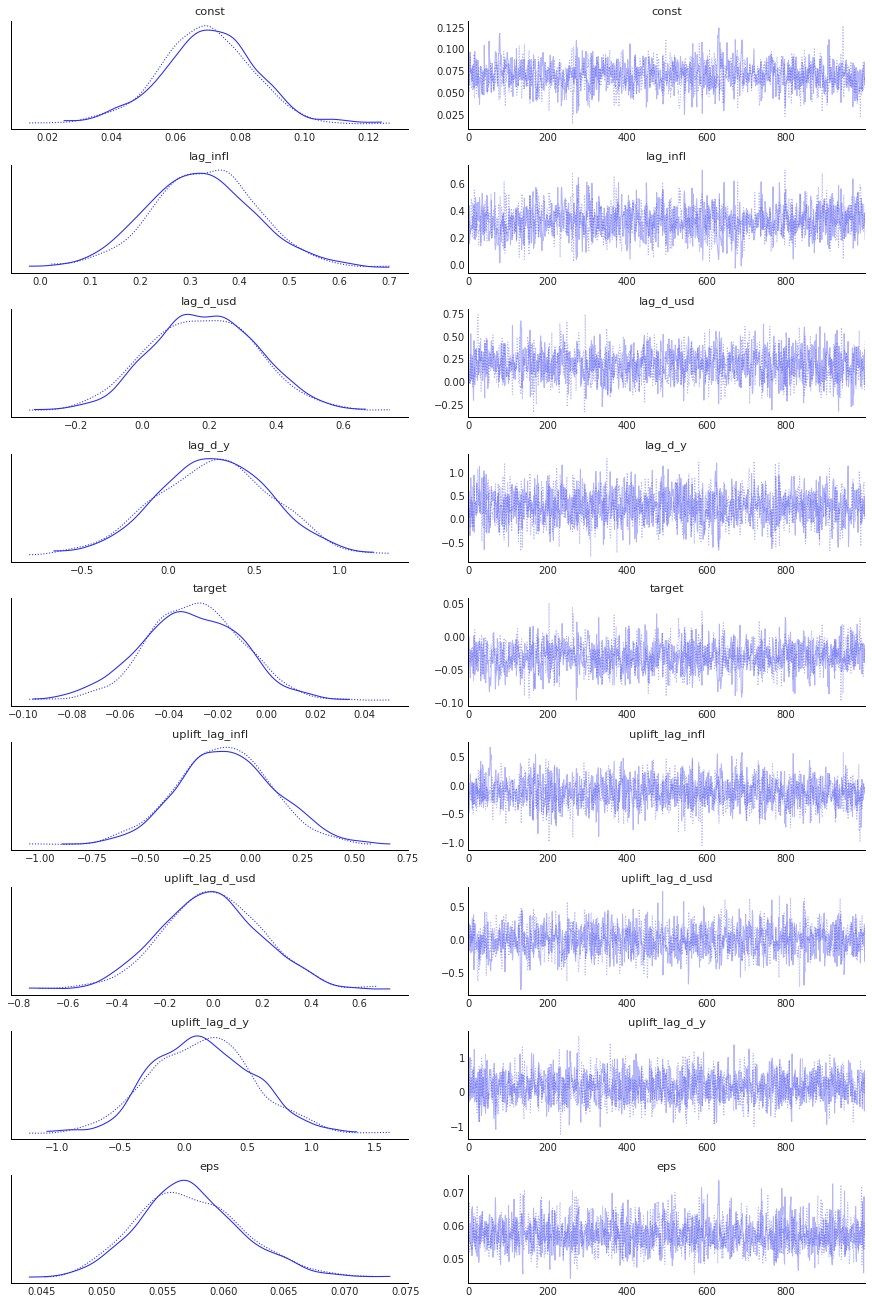

In [64]:
with pm.Model() as model_no_logic:
    INFL = pm.Data("INFL", data['infl'], mutable=True)
    TARGET = pm.Data("TARGET", data['target'], mutable=True)
    USD = pm.Data("USD", data['lag_d_usd'], mutable=True)
    Y = pm.Data("Y", data['lag_d_y'], mutable=True)
    INFL_LAG = pm.Data("INFL_LAG", data['lag_infl'], mutable=True)

    const = pm.Normal('const', 0, 0.5)
    lag_infl = pm.Normal('lag_infl', 0, 0.5)
    lag_d_usd = pm.Normal('lag_d_usd', 0, 0.5)
    lag_d_y = pm.Normal('lag_d_y', 0, 0.5)
    target = pm.Normal('target', 0, 0.5)
    uplift_lag_infl = pm.Normal('uplift_lag_infl', 0, 0.5)
    uplift_lag_d_usd = pm.Normal('uplift_lag_d_usd', 0, 0.5)
    uplift_lag_d_y = pm.Normal('uplift_lag_d_y', 0, 0.5)
    err = pm.Exponential('eps', 100)

    estimate = const + \
                lag_infl * INFL_LAG + lag_d_usd * USD + lag_d_y * Y + \
                (uplift_lag_infl * INFL_LAG + uplift_lag_d_usd * USD + uplift_lag_d_y * Y) * TARGET + \
                target * TARGET
    pm.Normal('infl', estimate, err, observed=INFL)
    
with model_no_logic:
    trace_no_logic = pm.sample()
    
az.plot_trace(trace_no_logic);

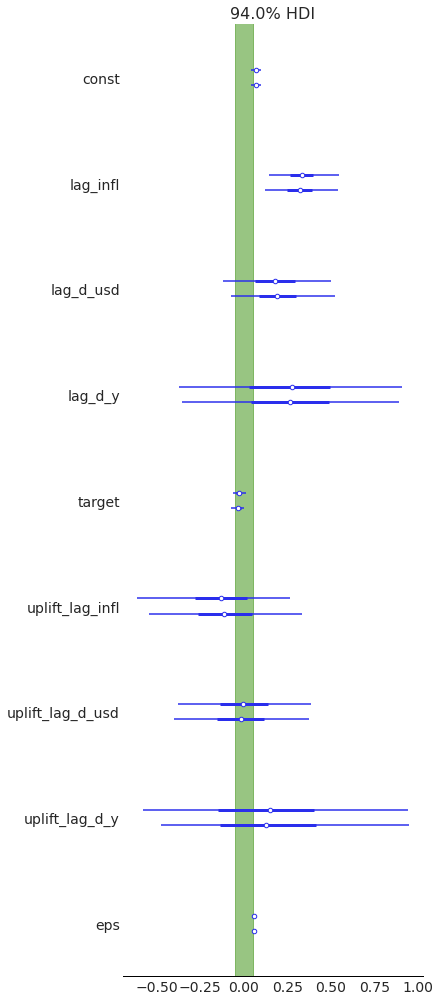

In [65]:
az.plot_forest(trace_no_logic, rope=[-0.05, 0.05]);

### Parameter recovery study

In [66]:
compiled_model = nutpie.compile_pymc_model(model)

/usr/local/lib/python3.9/dist-packages/aesara/link/numba/dispatch/basic.py:325: UserWarning: Numba will use object mode to run Assert{msg=Could not broadcast dimensions}'s perform method
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/aesara/link/numba/dispatch/basic.py:325: UserWarning: Numba will use object mode to run Assert{msg=Could not broadcast dimensions}'s perform method
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/aesara/link/numba/dispatch/basic.py:325: UserWarning: Numba will use object mode to run Assert{msg=Could not broadcast dimensions}'s perform method
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/aesara/link/numba/dispatch/basic.py:325: UserWarning: Numba will use object mode to run Assert{msg=Could not broadcast dimensions}'s perform method
  warnings.warn(


In [67]:
def delayed_sample(**data):
    return dask.delayed(nutpie.sample)(compiled_model.with_data(**data), progress_bar=False)

In [68]:
def pseudo_effect(uplift, col, data):   
    control = data.copy()[data.target==0]
    control.loc[control.shape[0]//2:,'target'] = 1
    control['infl'] += uplift * control[col] * control['target']
    control['lag_infl'] = control['infl'].shift()
    control.dropna(inplace=True)
    return control

In [69]:
prior = pm.sample_prior_predictive(100, model=model)
names = ['lag_d_usd', 'lag_d_y', 'lag_infl']

uplifts = []
probas = []

for col in names:
    print(col)
    uplift_to_try = prior.prior['uplift_'+col].values.flatten()
    uplift_to_try = np.sort(uplift_to_try[uplift_to_try < 0])
    uplifts.append(uplift_to_try)
    
    models = []
    for uplift in uplift_to_try:
        control = pseudo_effect(uplift, col, data)
        models.append(delayed_sample(INFL=control['infl'], TARGET=control['target'], USD=control['lag_d_usd'], Y=control['lag_d_y'], INFL_LAG=control['lag_infl']))
        
    with ProgressBar():
        all_sampled = dask.compute(models)

    row = [t.posterior['uplift_'+col].values.flatten() for t in all_sampled[0]]
    probs = [np.mean(distr < -0.05) for distr in row]
    probas.append(probs)

Sampling: [const, eps, infl, lag_d_usd, lag_d_y, lag_infl, target, uplift_lag_d_usd, uplift_lag_d_y, uplift_lag_infl]


lag_d_usd
[########################################] | 100% Completed | 22m 34s
lag_d_y
[########################################] | 100% Completed | 20m 3ss
lag_infl
[########################################] | 100% Completed | 20m 33s


In [70]:
with open('probas.txt', 'w') as f:
    for line in probas:
        f.write(f"{line}\n")

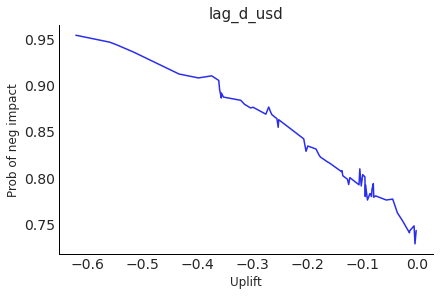

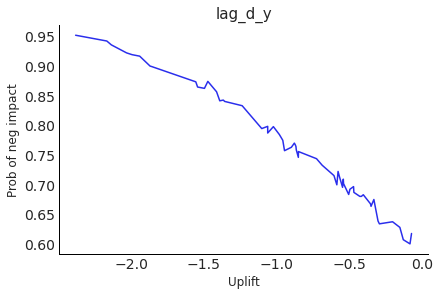

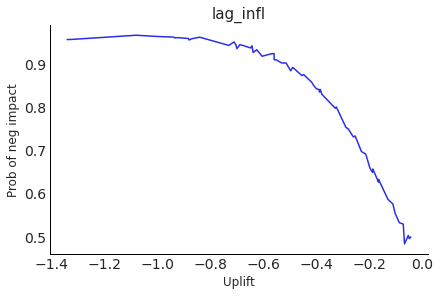

In [71]:
for uplift, prob, name in zip(uplifts, probas, names):
    plt.plot(uplift, prob)
    plt.title(name, size=15)
    plt.xlabel('Uplift', size=12)
    plt.ylabel('Prob of neg impact', size=12)
    plt.show()